In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install geopandas
!pip install shapely
!pip install tifffile
!pip install rasterio
!pip install h5py

import tensorflow as tf
from keras import datasets, layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import shapely
import geopandas as gpd
from shapely.geometry import Point, Polygon, asLineString, mapping
import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from descartes import PolygonPatch
from scipy import misc
import imageio
import PIL
import tifffile
import json
import seaborn as sns
from matplotlib.path import Path
from copy import copy
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, Birch
import matplotlib.cm as cm
import cv2
import os
import rasterio
from pyproj import Proj
from rasterio.mask import mask
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from scipy.stats import ttest_ind, f_oneway


Using TensorFlow backend.


In [0]:
path = '/content/drive/My Drive/stac'
train_data_df = pd.read_csv(os.path.join(path, 'image_resize/train/train_data_with_dist.csv'))
test_data_df = pd.read_csv(os.path.join(path, 'image_resize/test/test_data_with_dist.csv'))


## Some numbers...

In [5]:
train_data_df.columns

Index(['Unnamed: 0', 'id', 'label', 'centroid_x', 'centroid_y',
       'log_building_area', 'building_vertices', 'building_width',
       'building_height', 'place', 'R_mean', 'G_mean', 'B_mean', 'R_std',
       'G_std', 'B_std', 'H_mean', 'S_mean', 'V_mean', 'H_std', 'S_std',
       'V_std', 'Unnamed: 0.1', 'distance_10_all', 'distance_20_all',
       'distance_50_all', 'distance_10_train', 'distance_20_train',
       'distance_50_train', 'concrete_10_train', 'healthy_10_train',
       'incomplete_10_train', 'irregular_10_train', 'other_10_train',
       'concrete_20_train', 'healthy_20_train', 'incomplete_20_train',
       'irregular_20_train', 'other_20_train', 'concrete_50_train',
       'healthy_50_train', 'incomplete_50_train', 'irregular_50_train',
       'other_50_train'],
      dtype='object')

In [6]:
train_data_df.groupby('label').describe()

Unnamed: 0                ... other_50_train          
                     count          mean  ...            75%       max
label                                     ...                         
concrete_cement     1387.0   9589.484499  ...       0.071429  0.250000
healthy_metal       7381.0   7261.627693  ...       0.038462  0.333333
incomplete           668.0   5544.705090  ...       0.027778  0.200000
irregular_metal     5241.0   7197.360427  ...       0.041667  0.208333
other                193.0  11539.362694  ...       0.090909  0.178571

[5 rows x 328 columns]

In [7]:
train_data_df.groupby('label')[['log_building_area', 'building_vertices', 'building_width', 'building_height']].mean()

log_building_area  ...  building_height
label                               ...                 
concrete_cement         -19.141711  ...        10.486529
healthy_metal           -19.364917  ...         9.528244
incomplete              -19.483379  ...         8.454132
irregular_metal         -19.422416  ...         9.024974
other                   -19.481752  ...         8.836687

[5 rows x 4 columns]

In [8]:
train_data_df.groupby('label')[['concrete_10_train', 'healthy_10_train', 'incomplete_10_train', 'irregular_10_train', 'other_10_train',
                                'concrete_20_train', 'healthy_20_train', 'incomplete_20_train', 'irregular_20_train', 'other_20_train',
                                'concrete_50_train', 'healthy_50_train', 'incomplete_50_train', 'irregular_50_train', 'other_50_train',
                                ]].mean()

concrete_10_train  ...  other_50_train
label                               ...                
concrete_cement           0.211581  ...        0.054050
healthy_metal             0.170612  ...        0.034290
incomplete                0.161496  ...        0.025028
irregular_metal           0.172081  ...        0.035959
other                     0.205020  ...        0.065121

[5 rows x 15 columns]

In [9]:
val_name = []
train_mean = []
test_mean = []
p_val = []
for val in ['R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std', 
        'H_mean', 'S_mean', 'V_mean', 'H_std', 'S_std', 'V_std', 
        'distance_10_all', 'distance_20_all', 'distance_50_all', 
        'distance_10_train', 'distance_20_train', 'distance_50_train', 
        'concrete_10_train', 'healthy_10_train', 'incomplete_10_train', 'irregular_10_train', 'other_10_train',
       'concrete_20_train', 'healthy_20_train', 'incomplete_20_train', 'irregular_20_train', 'other_20_train', 
       'concrete_50_train', 'healthy_50_train', 'incomplete_50_train', 'irregular_50_train', 'other_50_train']:
  val_name.append(val)
  train_mean.append(train_data_df[[val]].mean()[0])
  test_mean.append(test_data_df[[val]].mean()[0])
  p_val.append(ttest_ind(train_data_df[[val]], test_data_df[[val]])[1])


pd.DataFrame({'val': val_name, 'train_mean': train_mean, 'test_mean': test_mean, 'p_val': p_val})


val  train_mean   test_mean                   p_val
0                R_mean  142.302962  142.509093    [0.6168896748422236]
1                G_mean  136.125108  136.173755    [0.9091921739945947]
2                B_mean  249.597979  249.681878   [0.15944189499672673]
3                 R_std   46.256123   46.089452   [0.29861273618180506]
4                 G_std   46.788308   46.638607     [0.364203478902823]
5                 B_std   32.323072   32.083362   [0.15375337935125313]
6                H_mean    0.263774    0.260576   [0.05310273377522614]
7                S_mean    0.124863    0.123867    [0.3566230270492843]
8                V_mean    0.585578    0.585615      [0.97928881703955]
9                 H_std    0.163890    0.161725  [0.019695638091039278]
10                S_std    0.090243    0.089547    [0.2990537167178564]
11                V_std    0.178211    0.177564    [0.3169929130751765]
12      distance_10_all    2.467989    2.468669    [0.9740520208455827]
13      distance_20_all   11.387223   11.422253    [0.6243208906062534]
14      distance_50_all   62.171419   62.225939    [0.8635432501148788]
15    distance_10_train    1.659314    1.641638    [0.3134377340540694]
16    distance_20_train    7.641560    7.603823    [0.4755406733035805]
17    distance_50_train   41.636853   41.685870    [0.8207782168868318]
18    concrete_10_train    0.174988    0.174362    [0.4274848000341438]
19     healthy_10_train    0.261748    0.260682   [0.47555833428082883]
20  incomplete_10_train    0.164927    0.165600    [0.2932366845352989]
21   irregular_10_train    0.240107    0.241225   [0.41858423401122336]
22       other_10_train    0.158230    0.158130    [0.8295356390498008]
23    concrete_20_train    0.138361    0.134916   [0.00397462565407287]
24     healthy_20_train    0.361353    0.361761    [0.8598042152323695]
25  incomplete_20_train    0.113007    0.114052   [0.22471692877272326]
26   irregular_20_train    0.293287    0.295294   [0.30900263141304896]
27       other_20_train    0.093991    0.093977    [0.9794334319490148]
28    concrete_50_train    0.106364    0.103516   [0.04244273143089864]
29     healthy_50_train    0.454336    0.455713    [0.5934031455370339]
30  incomplete_50_train    0.064888    0.065578    [0.3451981232704726]
31   irregular_50_train    0.337706    0.338908    [0.5566108605999762]
32       other_50_train    0.036705    0.036285   [0.31297990826167643]

In [10]:
train_data_df.groupby('label')[['R_mean', 'G_mean', 'B_mean',
                                'R_std', 'G_std', 'B_std',
                                'H_mean', 'S_mean', 'V_mean',
                                'H_std', 'S_std', 'V_std']].mean()

R_mean      G_mean  ...     S_std     V_std
label                                    ...                    
concrete_cement  128.771535  121.783794  ...  0.090250  0.200334
healthy_metal    153.378799  147.883966  ...  0.082941  0.177002
incomplete       131.355363  123.583728  ...  0.098418  0.172848
irregular_metal  133.137615  126.362067  ...  0.097470  0.173829
other            102.748144   98.016352  ...  0.144887  0.203007

[5 rows x 12 columns]

In [11]:
var_name = []
p_val = []

subset_concrete = train_data_df[train_data_df.label == 'concrete_cement']
subset_healthy = train_data_df[train_data_df.label == 'healthy_metal']
subset_incomplete = train_data_df[train_data_df.label == 'incomplete']
subset_irregular = train_data_df[train_data_df.label == 'irregular_metal']
subset_other = train_data_df[train_data_df.label == 'other']

for var in ['R_mean', 'G_mean', 'B_mean',
            'R_std', 'G_std', 'B_std',
            'H_mean', 'S_mean', 'V_mean',
            'H_std', 'S_std', 'V_std']:

  f_stat = f_oneway(subset_concrete[[var]],
                    subset_healthy[[var]],
                    subset_incomplete[[var]],
                    subset_irregular[[var]],
                    subset_other[[var]])
    
  var_name.append(var)
  p_val.append(f_stat[1])
  
pd.DataFrame({'var_name': var_name, 
             'p_val': p_val})

var_name                      p_val
0    R_mean                      [0.0]
1    G_mean                      [0.0]
2    B_mean   [2.268360990722157e-249]
3     R_std    [4.476916612030821e-74]
4     G_std    [2.985958196089743e-30]
5     B_std   [6.803977849964434e-293]
6    H_mean                      [0.0]
7    S_mean   [9.180046460963563e-237]
8    V_mean                      [0.0]
9     H_std  [2.5376743748918526e-130]
10    S_std  [2.1641639012299763e-128]
11    V_std    [3.204215592102548e-97]

In [12]:
train_data_df.groupby('label')[['distance_10_train', 'distance_20_train', 'distance_50_train',
                                'distance_10_all', 'distance_20_all', 'distance_50_all']].mean()

distance_10_train  ...  distance_50_all
label                               ...                 
concrete_cement           1.612112  ...        60.943043
healthy_metal             1.575803  ...        60.573770
incomplete                1.603293  ...        63.227545
irregular_metal           1.787254  ...        64.723526
other                     1.911917  ...        59.139896

[5 rows x 6 columns]

In [13]:
var_name = []
p_val = []

subset_concrete = train_data_df[train_data_df.label == 'concrete_cement']
subset_healthy = train_data_df[train_data_df.label == 'healthy_metal']
subset_incomplete = train_data_df[train_data_df.label == 'incomplete']
subset_irregular = train_data_df[train_data_df.label == 'irregular_metal']
subset_other = train_data_df[train_data_df.label == 'other']

for var in ['distance_10_train', 'distance_20_train', 'distance_50_train',
                                'distance_10_all', 'distance_20_all', 'distance_50_all']:

  f_stat = f_oneway(subset_concrete[[var]],
                    subset_healthy[[var]],
                    subset_incomplete[[var]],
                    subset_irregular[[var]],
                    subset_other[[var]])
    
  var_name.append(var)
  p_val.append(f_stat[1])
  
pd.DataFrame({'var_name': var_name, 
             'p_val': p_val})

var_name                     p_val
0  distance_10_train   [2.031995201201671e-21]
1  distance_20_train   [1.726144770053278e-12]
2  distance_50_train   [8.488672830421207e-22]
3    distance_10_all   [6.299727933973174e-39]
4    distance_20_all  [5.7161593739012575e-21]
5    distance_50_all  [1.4297653227451878e-24]

In [14]:
roof_mat_name = []
p_val_10 = []
p_val_20 = []
p_val_50 = []
for roof_mat in train_data_df.label.unique():

  temp = train_data_df[train_data_df.label == roof_mat]

  f_stat_10 = f_oneway(temp[['concrete_10_train']], 
                        temp[['healthy_10_train']],
                        temp[['incomplete_10_train']],
                        temp[['irregular_10_train']],
                        temp[['other_10_train']])
  f_stat_20 = f_oneway(temp[['concrete_20_train']], 
                        temp[['healthy_20_train']],
                        temp[['incomplete_20_train']],
                        temp[['irregular_20_train']],
                        temp[['other_20_train']])
  f_stat_50 = f_oneway(temp[['concrete_50_train']], 
                        temp[['healthy_50_train']],
                        temp[['incomplete_50_train']],
                        temp[['irregular_50_train']],
                        temp[['other_50_train']])
    
  roof_mat_name.append(roof_mat)
  p_val_10.append(f_stat_10[1])
  p_val_20.append(f_stat_20[1])
  p_val_50.append(f_stat_50[1])

pd.DataFrame({'roof_mat': roof_mat_name, 
             'p_val_10': p_val_10,
             'p_val_20': p_val_20,
             'p_val_50': p_val_50})

roof_mat  ...                   p_val_50
0  concrete_cement  ...                      [0.0]
1  irregular_metal  ...                      [0.0]
2    healthy_metal  ...                      [0.0]
3       incomplete  ...                      [0.0]
4            other  ...  [1.1991799101577325e-151]

[5 rows x 4 columns]

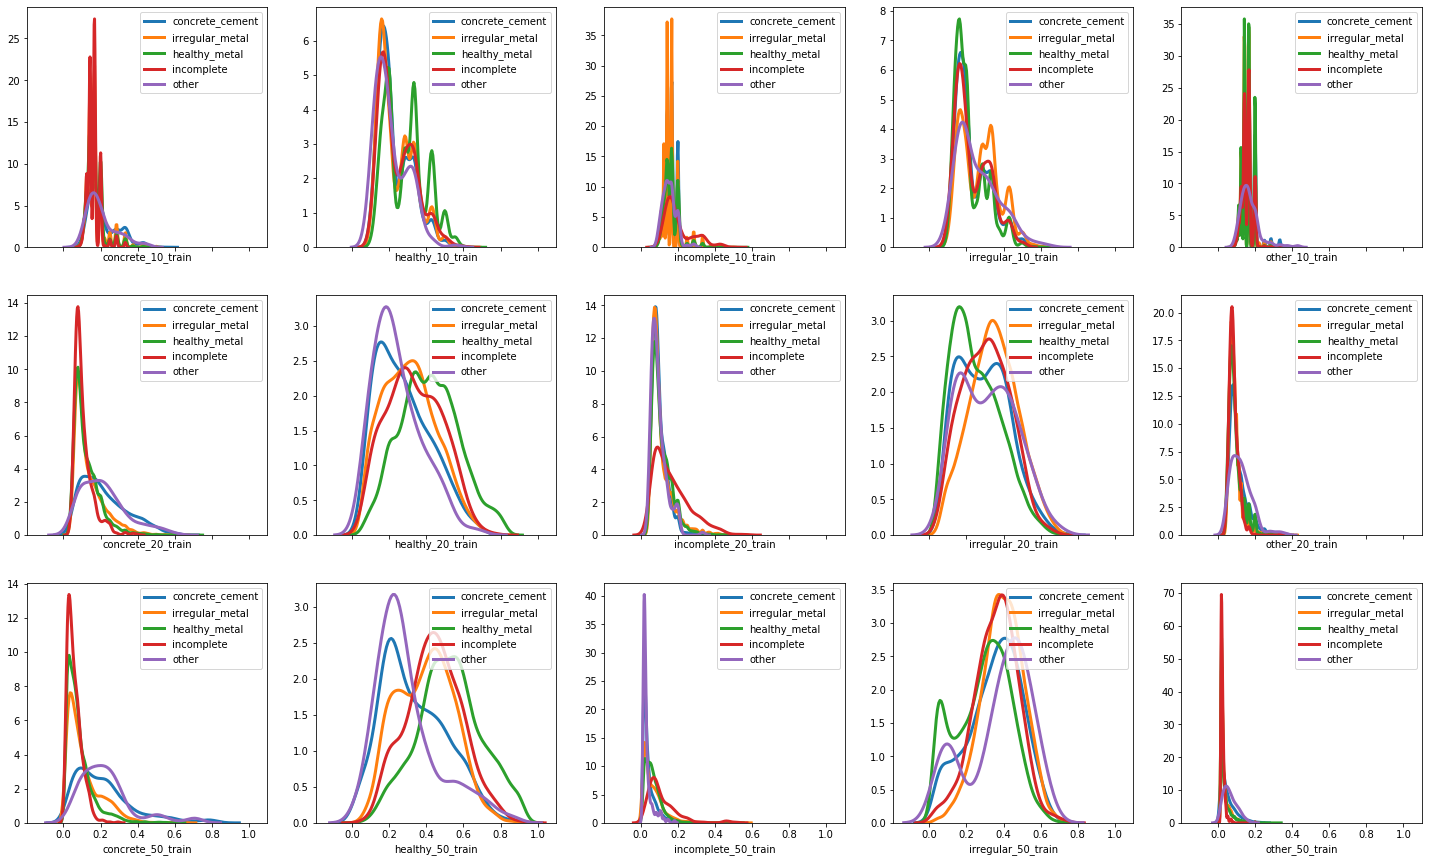

In [15]:

f, axes = plt.subplots(3, 5, figsize=(25, 15), sharex=True)
for roof_mat in train_data_df.label.unique():

    subset = train_data_df[train_data_df.label == roof_mat]
    
    # Draw the density plot
    for i, j in enumerate(['concrete_10_train', 'healthy_10_train', 'incomplete_10_train', 'irregular_10_train', 'other_10_train']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[0, i])
    for i, j in enumerate(['concrete_20_train', 'healthy_20_train', 'incomplete_20_train', 'irregular_20_train', 'other_20_train']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[1, i])
    for i, j in enumerate(['concrete_50_train', 'healthy_50_train', 'incomplete_50_train', 'irregular_50_train', 'other_50_train']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[2, i])
    

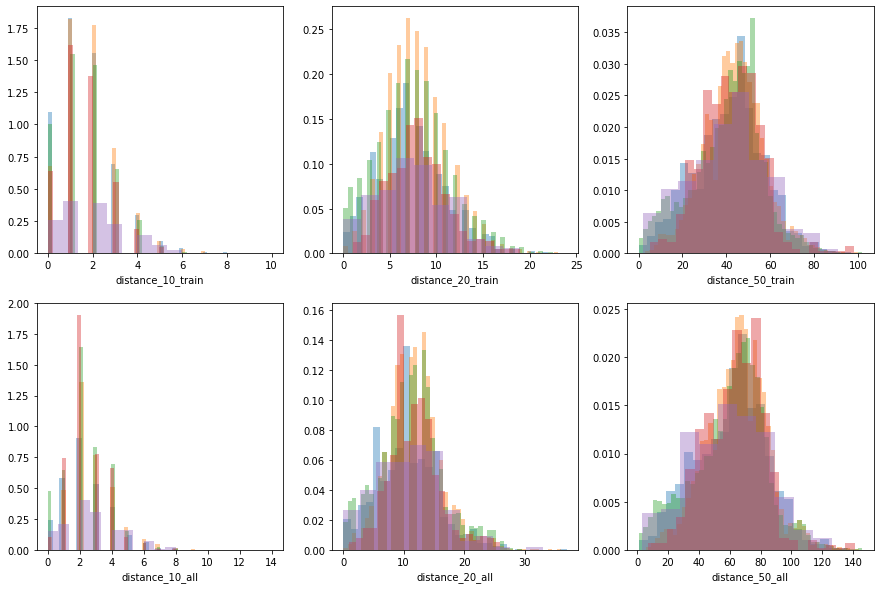

In [16]:

f, axes = plt.subplots(2, 3, figsize=(15, 10))
for roof_mat in train_data_df.label.unique():

    subset = train_data_df[train_data_df.label == roof_mat]
    
    # Draw the density plot
    for i, j in enumerate(['distance_10_train', 'distance_20_train', 'distance_50_train']):
      sns.distplot(subset[j], hist = True, kde = False,
                   norm_hist = True,
                  hist_kws = {'linewidth' : 1},
                   kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[0, i])
    
    for i, j in enumerate(['distance_10_all', 'distance_20_all', 'distance_50_all']):
      sns.distplot(subset[j], hist = True, kde = False,
                   norm_hist = True,
                   hist_kws = {'linewidth' : 1},
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[1, i])
        

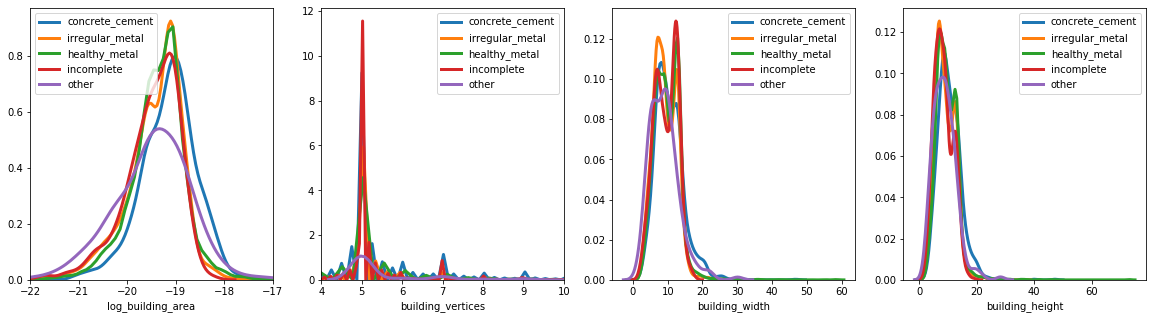

In [17]:

f, axes = plt.subplots(1, 4, figsize=(20, 5))
for roof_mat in train_data_df.label.unique():

    subset = train_data_df[train_data_df.label == roof_mat]
    
    # Draw the density plot
    for i, j in enumerate(['log_building_area', 'building_vertices', 'building_width', 'building_height']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[i])

axes[0].set_xlim(-22, -17)
axes[1].set_xlim(4, 10)
# axes[2].set_xlim(-22, -17)
# axes[3].set_xlim(-22, -17)
plt.show()    

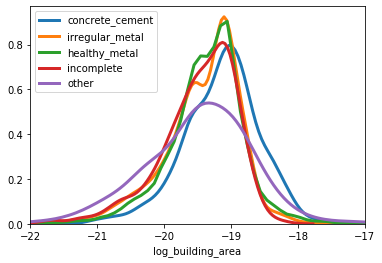

In [18]:
fig, ax = plt.subplots()
for roof_mat in train_data_df.label.unique():
  subset = train_data_df[train_data_df.label == roof_mat]
  sns.distplot(subset.log_building_area, hist = False, kde = True,
              kde_kws = {'linewidth': 3},
              label = roof_mat,
              ax = ax)

ax.set_xlim(-22, -17)  
plt.show()

In [19]:
train_data_df.groupby('label')[['distance_10_train', 'distance_20_train', 'distance_50_train',
                                'distance_10_all', 'distance_20_all', 'distance_50_all']].mean()

distance_10_train  ...  distance_50_all
label                               ...                 
concrete_cement           1.612112  ...        60.943043
healthy_metal             1.575803  ...        60.573770
incomplete                1.603293  ...        63.227545
irregular_metal           1.787254  ...        64.723526
other                     1.911917  ...        59.139896

[5 rows x 6 columns]

In [20]:
df_temp = pd.concat([train_data_df.label, pd.get_dummies(train_data_df.building_vertices)], axis = 1)
df_temp.groupby('label').mean()

4         5         6   ...        28        30        37
label                                          ...                              
concrete_cement  0.000721  0.759193  0.041817  ...  0.000000  0.000000  0.000000
healthy_metal    0.000813  0.888362  0.016935  ...  0.000135  0.000135  0.000271
incomplete       0.001497  0.898204  0.019461  ...  0.000000  0.000000  0.000000
irregular_metal  0.000572  0.909941  0.020988  ...  0.000000  0.000000  0.000000
other            0.000000  0.740933  0.051813  ...  0.000000  0.000000  0.000000

[5 rows x 23 columns]

In [21]:
df_temp.groupby('label').sum().astype(int)

4     5    6    7   8    9   10  ...  20  23  24  26  28  30  37
label                                             ...                            
concrete_cement   1  1053   58  141  33   54  13  ...   1   0   0   0   0   0   0
healthy_metal     6  6557  125  313  62  127  29  ...   1   1   2   2   1   1   2
incomplete        1   600   13   33   7    8   1  ...   0   0   0   0   0   0   0
irregular_metal   3  4769  110  198  61   55  13  ...   0   1   0   0   0   0   0
other             0   143   10   20   5    7   0  ...   0   0   0   0   0   0   0

[5 rows x 23 columns]

In [22]:
df_temp = pd.concat([train_data_df.label, (train_data_df.building_vertices >= 7)], axis = 1)
df_temp.groupby('label').mean()

building_vertices
label                             
concrete_cement           0.198270
healthy_metal             0.093890
incomplete                0.080838
irregular_metal           0.068498
other                     0.207254

In [23]:
train_data_df.groupby(['building_vertices', 'label'])['label'].size().unstack(fill_value = 0)

label              concrete_cement  healthy_metal  ...  irregular_metal  other
building_vertices                                  ...                        
4                                1              6  ...                3      0
5                             1053           6557  ...             4769    143
6                               58            125  ...              110     10
7                              141            313  ...              198     20
8                               33             62  ...               61      5
9                               54            127  ...               55      7
10                              13             29  ...               13      0
11                              13             64  ...               16      5
12                              10             15  ...                5      2
13                               6             34  ...                2      0
14                               0              9  ...                3      0
15                               3             18  ...                1      0
16                               1              3  ...                3      1
17                               0              3  ...                0      0
18                               0              2  ...                0      0
19                               0              4  ...                1      0
20                               1              1  ...                0      0
23                               0              1  ...                1      0
24                               0              2  ...                0      0
26                               0              2  ...                0      0
28                               0              1  ...                0      0
30                               0              1  ...                0      0
37                               0              2  ...                0      0

[23 rows x 5 columns]

In [0]:

f, axes = plt.subplots(2, 3, figsize=(20, 10))
for roof_mat in train_data_df.label.unique():

    subset = train_data_df[train_data_df.label == roof_mat]
    
    # Draw the density plot
    for i, j in enumerate(['R_mean', 'G_mean', 'B_mean']):
      sns.distplot(subset[j] / 255., hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[0, i])
    for i, j in enumerate(['R_std', 'G_std', 'B_std']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[1, i])
    

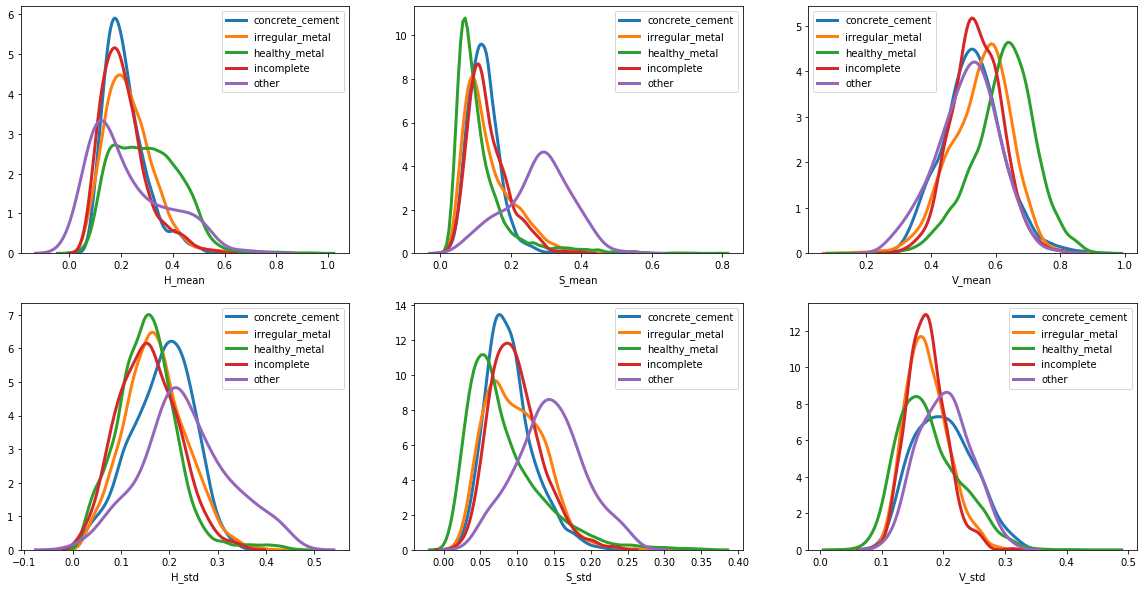

In [7]:

f, axes = plt.subplots(2, 3, figsize=(20, 10))
for roof_mat in train_data_df.label.unique():

    subset = train_data_df[train_data_df.label == roof_mat]
    
    # Draw the density plot
    for i, j in enumerate(['H_mean', 'S_mean', 'V_mean']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[0, i])
    for i, j in enumerate(['H_std', 'S_std', 'V_std']):
      sns.distplot(subset[j], hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = roof_mat,
                  ax = axes[1, i])
    

## Example images

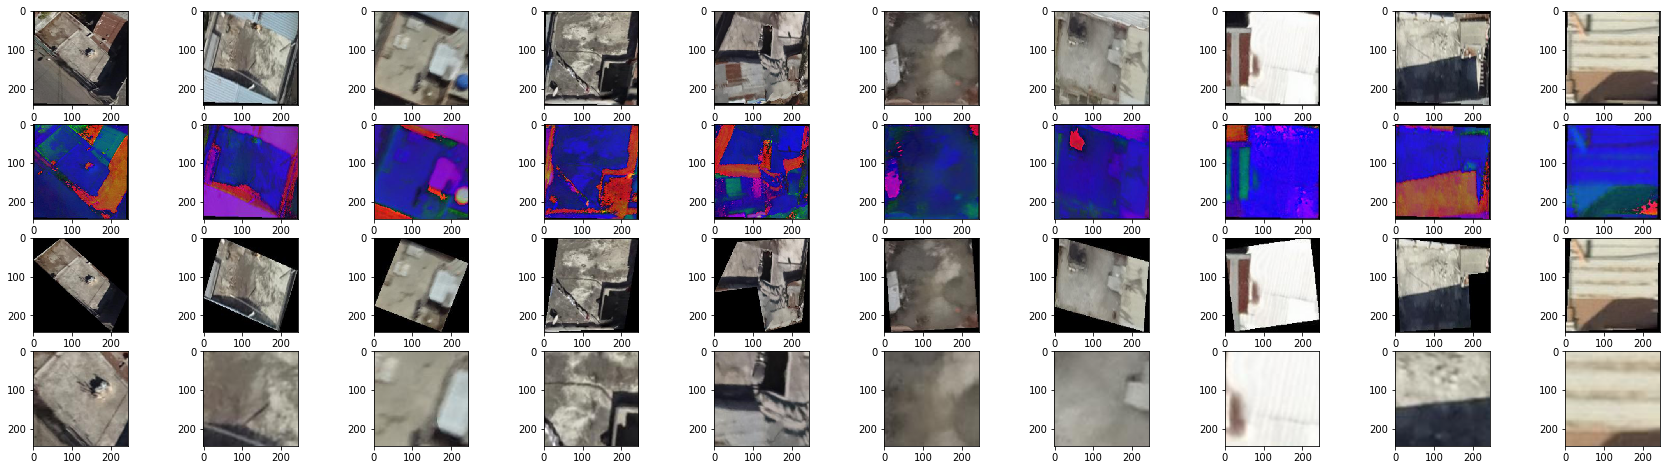

In [11]:
# concrete_cement
train_data_sub = train_data_df[train_data_df.label == 'concrete_cement'].id.sample(n = 10)
fig, axes = plt.subplots(4, 10, figsize = (30, 8))
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[0, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize_hsv/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[1, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_mask/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[2, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_core/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[3, i].imshow(image_array)

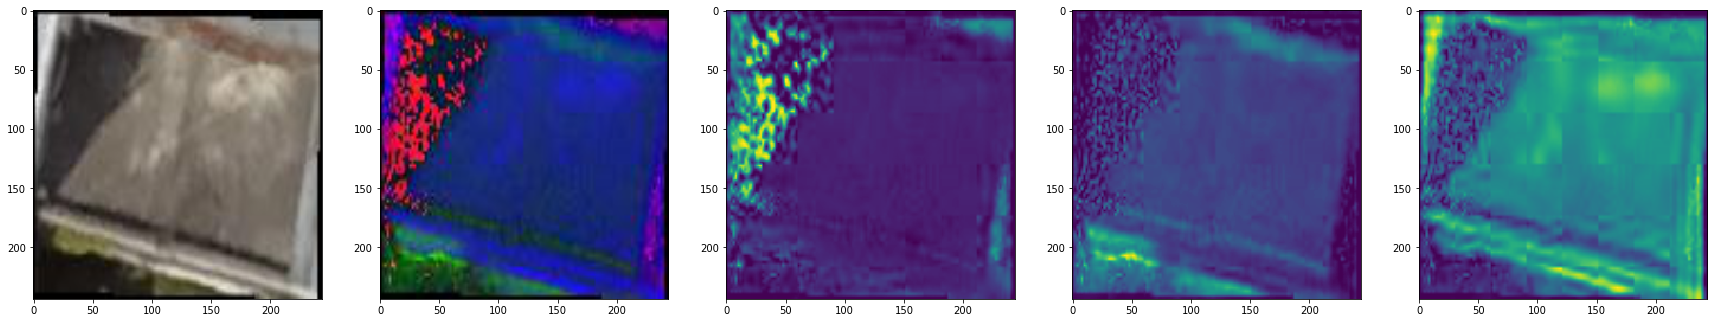

In [0]:
filename = train_data_sub.iloc[1] + '.jpg'
fig, axes = plt.subplots(1, 5, figsize = (30, 20))
image_array = plt.imread(os.path.join(path, 'image_resize/train/', filename))
image_array = cv2.resize(image_array, (244, 244))
axes[0].imshow(image_array)
image_array = plt.imread(os.path.join(path, 'image_resize_hsv/train/', filename))
image_array = cv2.resize(image_array, (244, 244))
axes[1].imshow(image_array)
axes[2].imshow(image_array[:,:,0])
axes[3].imshow(image_array[:,:,1])
axes[4].imshow(image_array[:,:,2])
plt.show()


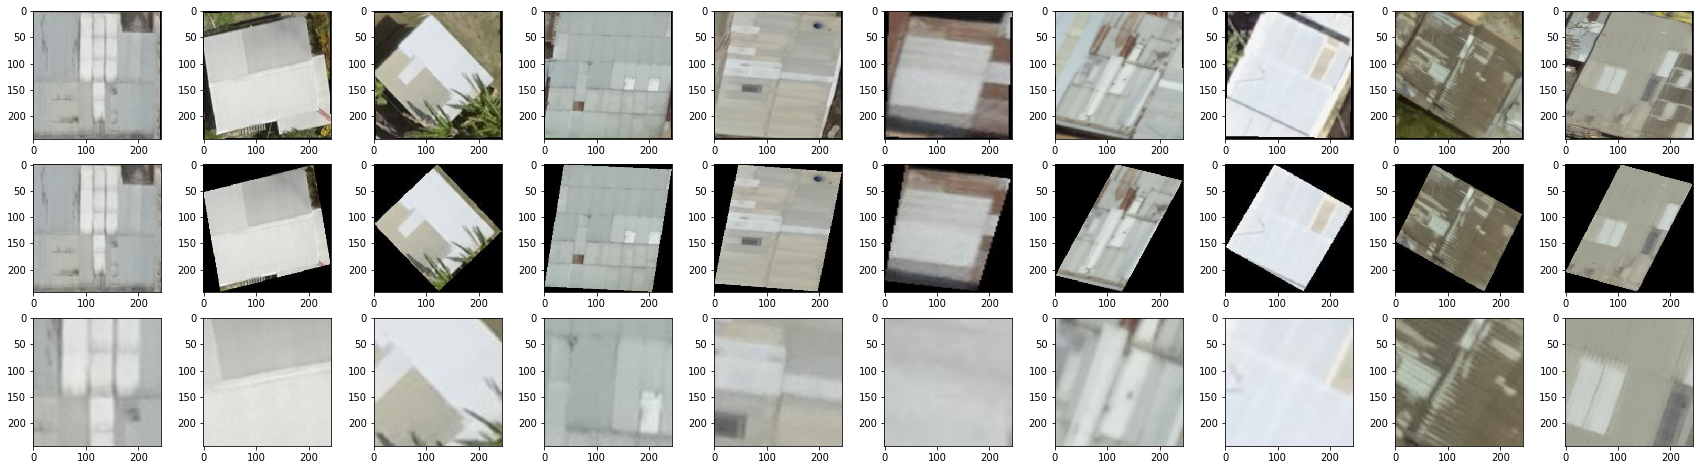

In [0]:
# healthy_metal
train_data_sub = train_data_df[train_data_df.label == 'healthy_metal'].id.sample(n = 10)
fig, axes = plt.subplots(3, 10, figsize = (30, 8))
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[0, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize_hsv/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[1, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_mask/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[2, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_core/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[3, i].imshow(image_array)

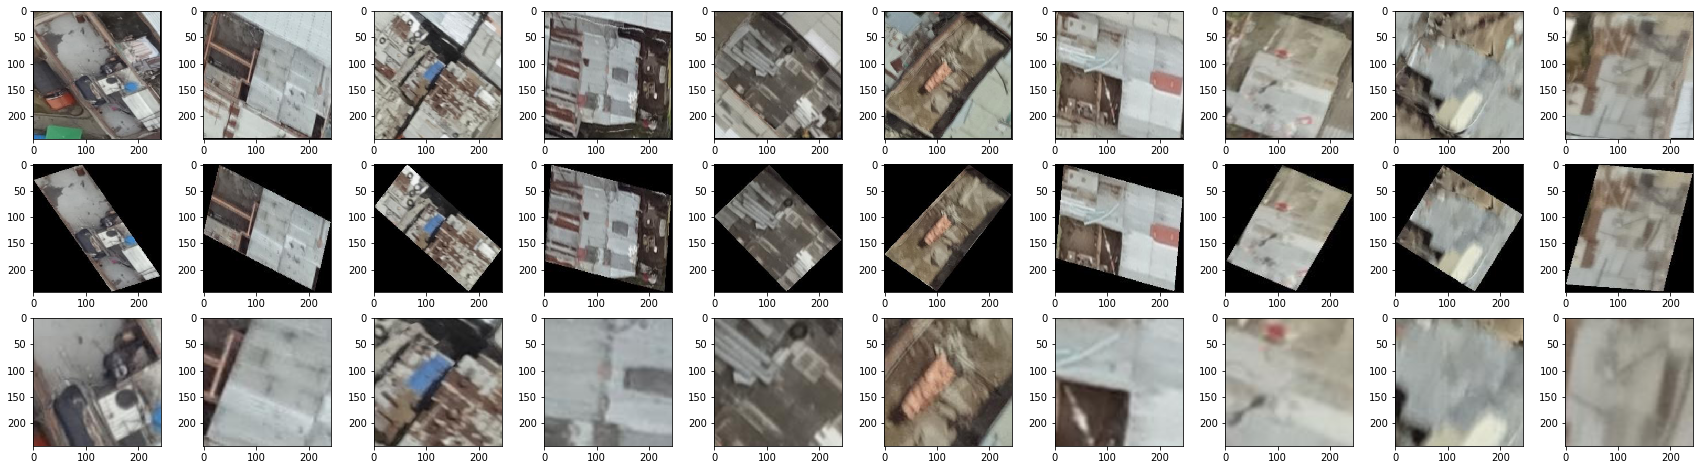

In [0]:
# incomplete
train_data_sub = train_data_df[train_data_df.label == 'incomplete'].id.sample(n = 10)
fig, axes = plt.subplots(3, 10, figsize = (30, 8))
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[0, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize_hsv/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[1, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_mask/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[2, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_core/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[3, i].imshow(image_array)

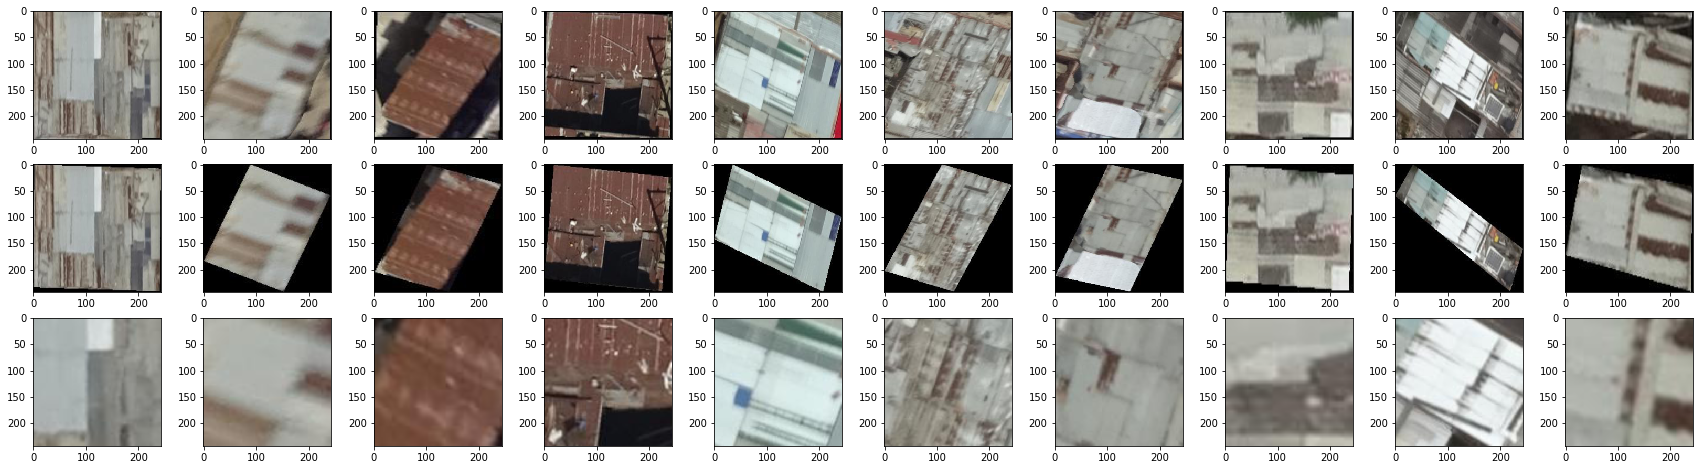

In [0]:
# irregular_metal
train_data_sub = train_data_df[train_data_df.label == 'irregular_metal'].id.sample(n = 10)
fig, axes = plt.subplots(3, 10, figsize = (30, 8))
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[0, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize_hsv/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[1, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_mask/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[2, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_core/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[3, i].imshow(image_array)

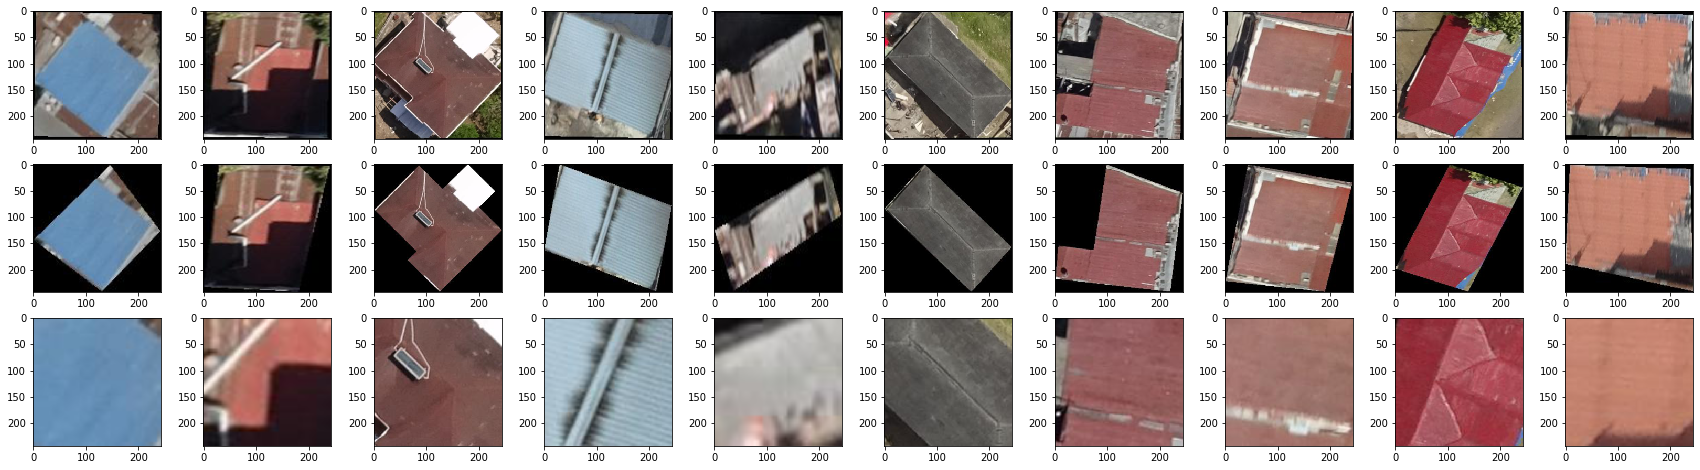

In [0]:
# other
train_data_sub = train_data_df[train_data_df.label == 'other'].id.sample(n = 10)
fig, axes = plt.subplots(3, 10, figsize = (30, 8))
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[0, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_resize_hsv/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[1, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_mask/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[2, i].imshow(image_array)
for i in range(10):
  filename = train_data_sub.iloc[i] + '.jpg'
  image_array = plt.imread(os.path.join(path, 'image_core/train/', filename))
  image_array = cv2.resize(image_array, (244, 244))
  axes[3, i].imshow(image_array)